<a href="https://colab.research.google.com/github/HarshaVishak/Topic-based-Argument-checking/blob/main/EDA_NLP_CTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
import pandas as pd

url = 'https://github.com/HarshaVishak/Topic-based-Argument-checking/blob/main/train.csv?raw=true'
df2 = pd.read_csv(url)

Using Head to see all the columns present in the data

In [94]:
df2.head()

,topic,the concept of the topic,candidate,candidate masked,label,wikipedia article name,wikipedia url
0,We should limit executive compensation,executive compensation,A say on pay - a non-binding vote of the gener...,A say on pay - a non-binding vote of the gener...,0,Executive pay,https://en.wikipedia.org/wiki/Executive_pay
1,We should limit executive compensation,executive compensation,"A February 2009 report, published by the Insti...","A February 2009 report, published by the Insti...",1,Executive pay,https://en.wikipedia.org/wiki/Executive_pay
2,We should limit executive compensation,executive compensation,The Financial Crisis has had a relatively smal...,The Financial Crisis has had a relatively smal...,0,Executive pay,https://en.wikipedia.org/wiki/Executive_pay
3,We should limit executive compensation,executive compensation,"1990-1992 Lineberger Cancer Center, SPA person...","1990-1992 Lineberger Cancer Center, SPA person...",0,Edison Liu,https://en.wikipedia.org/wiki/Edison_Liu
4,We should limit executive compensation,executive compensation,Countering the public uproar over excessive ex...,Countering the public uproar over excessive TO...,0,Jack Welch,https://en.wikipedia.org/wiki/Jack_Welch


## EDA
The aim of the following blocks is to understand more about our data

# Topics and claims
Counting the number of unique topics and average number of claims per topic

In [95]:
topics = df2['topic'].values.tolist()
list_set = set(topics) 
    # convert the set to the list 
unique_topics = (list(list_set)) 
count  = 0
for el in unique_topics:
  count=count+1
(no_of_rows,no_of_columns) = df2.shape  
print("The number of topics is-",count," and the average number of claims per topic is -",no_of_rows/count)



The number of topics is- 83  and the average number of claims per topic is - 48.975903614457835




0.36 of the candidates are judged to be valid claims, so the dataset is skewed towards negative predictions

In [96]:
labels = df2['label'].values.tolist()
print("As a fraction the number of positive claims are" , sum(labels)/no_of_rows, "of the total")

As a fraction the number of positive claims are 0.36875768757687577 of the total


Now we try and see how many claims and candidates are present for every topic, and plot the distribution to see how consistent it is and if it varies greatly oer topic

In [97]:
claim_count = {}
candidate_count = {}
label_list = df2['label']
for ele in unique_topics:
  claim_count[ele] = 0
  candidate_count[ele] = 0
for ind in df2.index:
  candidate_count[df2['topic'][ind]] = candidate_count[df2['topic'][ind]]+1
  if label_list[ind] == 1:
     claim_count[df2['topic'][ind]] = claim_count[df2['topic'][ind]]+1

<BarContainer object of 83 artists>

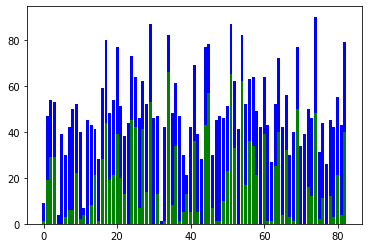

In [98]:
import matplotlib.pyplot as plt

plt.bar(range(len(candidate_count)), list(candidate_count.values()),color = 'b')

plt.bar(range(len(candidate_count)), list(claim_count.values()),color = 'g')


<BarContainer object of 45 artists>

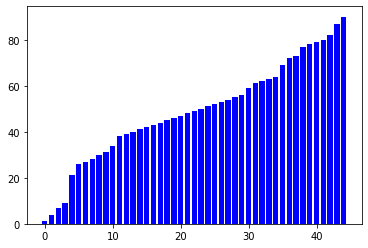

In [99]:
sorted_values = sorted(candidate_count.values()) # Sort the values
sorted_dict = {}

for i in sorted_values:
    for k in candidate_count.keys():
        if candidate_count[k] == i:
            sorted_dict[k] = candidate_count[k]
            break
sorted_values2 = sorted(claim_count.values()) # Sort the values
plt.bar(range(len(sorted_dict)), list(sorted_dict.values()),color = 'b')


The bar graph above shows the huge variation in number of candidate claims per topic. For the purpose of training this might be an issue for the topics that have really few candidate claims. So as a part of the pre processing we may need to drop some of these topics from the training data

# Sentiment ananlysis
 For the next part of the EDA we will try and apply basic sentiment analysis on the claims to see if there is any correlation with the sentiment score and the nature of the statement ,ie whether it is a relevant claim or not

In [100]:
import nltk

In [101]:
candidates  = df2['candidate'].values.tolist()
candidates_lower =[]
text = candidates[1]
text = text.lower()
text


'a february 2009 report, published by the institute for policy studies notes the impact excessive executive compensation has on taxpayers: u.s. taxpayers subsidize excessive executive compensation - by more than $20 billion per year - via a variety of tax and accounting loopholes.'

In [102]:
import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
nltk.download('vader_lexicon')
nltk.download('punkt')

import matplotlib.pyplot as plt
%matplotlib inline


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [103]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [104]:
candidates  = df2['candidate'].values.tolist()
scores_col = [0]*len(candidates)
scores_pos = [0]*len(candidates)
scores_neg = [0]*len(candidates)
scores_neu = [0]*len(candidates)

for ind in range(0,len(candidates)):
  scores_col[ind] = sid.polarity_scores(candidates[ind])
  scores_pos[ind] = scores_col[ind]['pos']
  scores_neg[ind] = scores_col[ind]['neg']
  scores_neu[ind] = scores_col[ind]['neu']
df2['Positive score'] = scores_pos
df2['Negative score'] = scores_neg
df2['Neutral score'] = scores_neu

df2.head()

,topic,the concept of the topic,candidate,candidate masked,label,wikipedia article name,wikipedia url,Positive score,Negative score,Neutral score
0,We should limit executive compensation,executive compensation,A say on pay - a non-binding vote of the gener...,A say on pay - a non-binding vote of the gener...,0,Executive pay,https://en.wikipedia.org/wiki/Executive_pay,0.132,0.123,0.746
1,We should limit executive compensation,executive compensation,"A February 2009 report, published by the Insti...","A February 2009 report, published by the Insti...",1,Executive pay,https://en.wikipedia.org/wiki/Executive_pay,0.000,0.000,1.000
2,We should limit executive compensation,executive compensation,The Financial Crisis has had a relatively smal...,The Financial Crisis has had a relatively smal...,0,Executive pay,https://en.wikipedia.org/wiki/Executive_pay,0.000,0.355,0.645
3,We should limit executive compensation,executive compensation,"1990-1992 Lineberger Cancer Center, SPA person...","1990-1992 Lineberger Cancer Center, SPA person...",0,Edison Liu,https://en.wikipedia.org/wiki/Edison_Liu,0.000,0.386,0.614
4,We should limit executive compensation,executive compensation,Countering the public uproar over excessive ex...,Countering the public uproar over excessive TO...,0,Jack Welch,https://en.wikipedia.org/wiki/Jack_Welch,0.072,0.031,0.897


Now that we have the scores added to the dataframe we can find which one has the highest correlation between the three.

In [105]:
df2.corr(method = 'pearson')

,label,Positive score,Negative score,Neutral score
label,1.000000,0.027063,0.074750,-0.083462
Positive score,0.027063,1.000000,-0.278625,-0.634205
Negative score,0.074750,-0.278625,1.000000,-0.565838
Neutral score,-0.083462,-0.634205,-0.565838,1.000000


No column has a strong correlation with the label column, which implies that there is more nuance and depth in how a candidate is judged to be a claim, rather than just it being very positive or very negative.

# Parse tree subject
We try and fid the subject word of each candidate sentence

For this we install the spacy library into colab


In [106]:
!python -m spacy download en_core_web_md

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [107]:
nlp = spacy.load("en_core_web_sm")

In [108]:
subtreesubjects = []
for text in candidates :
  doc = nlp(text)
  subjectsperrow = []
  for token in doc :
    if(token.dep_ == "nsubj"):
      subjectsperrow.append(token.text)
  subtreesubjects.append(subjectsperrow)

The above code finds the subject words in each candidate sentence, we do this to get a broad idea if the candidate subjects are broadly similar to the topic

In [109]:
import en_core_web_lg
nlp = en_core_web_lg.load()

In [110]:
df2['Candidate Subjects'] = subtreesubjects
df2.head()

,topic,the concept of the topic,candidate,candidate masked,label,wikipedia article name,wikipedia url,Positive score,Negative score,Neutral score,Candidate Subjects
0,We should limit executive compensation,executive compensation,A say on pay - a non-binding vote of the gener...,A say on pay - a non-binding vote of the gener...,0,Executive pay,https://en.wikipedia.org/wiki/Executive_pay,0.132,0.123,0.746,[]
1,We should limit executive compensation,executive compensation,"A February 2009 report, published by the Insti...","A February 2009 report, published by the Insti...",1,Executive pay,https://en.wikipedia.org/wiki/Executive_pay,0.000,0.000,1.000,"[report, compensation, taxpayers]"
2,We should limit executive compensation,executive compensation,The Financial Crisis has had a relatively smal...,The Financial Crisis has had a relatively smal...,0,Executive pay,https://en.wikipedia.org/wiki/Executive_pay,0.000,0.355,0.645,[Crisis]
3,We should limit executive compensation,executive compensation,"1990-1992 Lineberger Cancer Center, SPA person...","1990-1992 Lineberger Cancer Center, SPA person...",0,Edison Liu,https://en.wikipedia.org/wiki/Edison_Liu,0.000,0.386,0.614,[]
4,We should limit executive compensation,executive compensation,Countering the public uproar over excessive ex...,Countering the public uproar over excessive TO...,0,Jack Welch,https://en.wikipedia.org/wiki/Jack_Welch,0.072,0.031,0.897,"[Welch, compensation]"


In [111]:
similarity_scores = []
count_blanks = 0
for index in range(0,len(topics)):
  doc4 = nlp(topics[index])
  text = ""
  for word in subtreesubjects[index]:
    text = text+" "+word
    
  if(text ==""):
    similarity_scores.append(0)
    count_blanks = count_blanks+1
  if(text!=""):
    doc5 = nlp(text)
    similarity_scores.append(doc4.similarity(doc5))
  

/usr/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__mai

The above code is used to calculate the similarity scores between the topics and subjects of the candidate sentences. 340 sentences were not identified to have sentences

In [112]:
count_blanks

340

In [113]:
df2['Similarity Scores'] = similarity_scores
df2.head()

,topic,the concept of the topic,candidate,candidate masked,label,wikipedia article name,wikipedia url,Positive score,Negative score,Neutral score,Candidate Subjects,Similarity Scores
0,We should limit executive compensation,executive compensation,A say on pay - a non-binding vote of the gener...,A say on pay - a non-binding vote of the gener...,0,Executive pay,https://en.wikipedia.org/wiki/Executive_pay,0.132,0.123,0.746,[],0.000000
1,We should limit executive compensation,executive compensation,"A February 2009 report, published by the Insti...","A February 2009 report, published by the Insti...",1,Executive pay,https://en.wikipedia.org/wiki/Executive_pay,0.000,0.000,1.000,"[report, compensation, taxpayers]",0.742307
2,We should limit executive compensation,executive compensation,The Financial Crisis has had a relatively smal...,The Financial Crisis has had a relatively smal...,0,Executive pay,https://en.wikipedia.org/wiki/Executive_pay,0.000,0.355,0.645,[Crisis],0.433720
3,We should limit executive compensation,executive compensation,"1990-1992 Lineberger Cancer Center, SPA person...","1990-1992 Lineberger Cancer Center, SPA person...",0,Edison Liu,https://en.wikipedia.org/wiki/Edison_Liu,0.000,0.386,0.614,[],0.000000
4,We should limit executive compensation,executive compensation,Countering the public uproar over excessive ex...,Countering the public uproar over excessive TO...,0,Jack Welch,https://en.wikipedia.org/wiki/Jack_Welch,0.072,0.031,0.897,"[Welch, compensation]",0.491948
